# Introduction to Machine Learning

In this chapter, we’ll briefly review machine learning concepts that will be relevant later. We’ll focus in particular on the problem of **prediction**, that is, to model some output variable as a function of observed input covariates.

In [1]:
# importing the packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import warnings
from sklearn.metrics import mean_squared_error
from SyncRNG import SyncRNG
warnings.filterwarnings('ignore')
%matplotlib inline

In this section, we will use simulated data. In the next section we’ll load a real dataset.

In [2]:
# Simulating data

# Sample size
n = 500

# Generating covariate X ~ Unif[-4, 4]
x = np.linspace(-4,4, n) #with linspace we can generate a vector of "n" numbers between a range of numbers

random.shuffle(x) 
mu = np.where(x<0, np.cos(2*x), 1 - np.sin(x) )
y = mu + 1*np.random.normal(size =n)

# collecting observations in a data.frame object
data = pd.DataFrame(np.array([x,y]).T, columns=['x','y'])

data = data.assign(mu = mu)
data = data.sort_values("x")

The following shows how the two variables `x` and `y` relate. Note that the relationship is nonlinear.

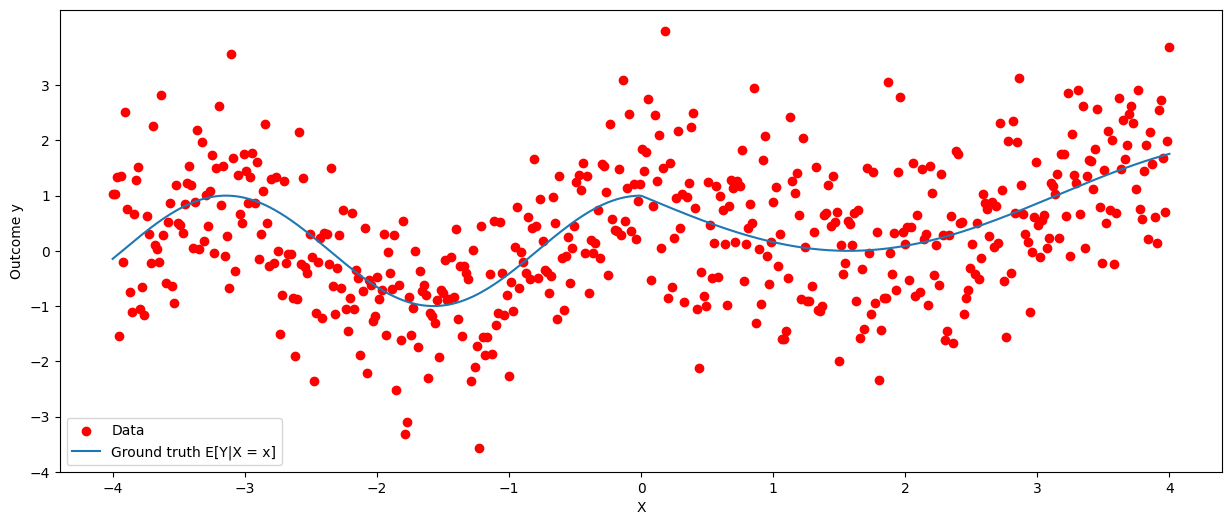

In [3]:
plt.figure(figsize=(15,6))
plt.scatter("x", "y", data = data, color = 'red', label = 'Data')
plt.plot("x", "mu", data = data, label = "Ground truth E[Y|X = x]")
plt.yticks(np.arange(-4,4,1))
plt.legend()
plt.xlabel("X")
plt.ylabel("Outcome y");

Note: If you’d like to run the code below on a different dataset, you can replace the dataset above with another `data.frame` of your choice, and redefine the key variable identifiers (`outcome`, `covariates`) accordingly. Although we try to make the code as general as possible, you may also need to make a few minor changes to the code below; read the comments carefully.

## Key concepts

The prediction problem is to accurately guess the value of some output variable $Y_i$ from input variables $X_i$. For example, we might want to predict “house prices given house characteristics such as the number of rooms, age of the building, and so on. The relationship between input and output is modeled in very general terms by some function

$$
  Y_i = f(X_i) + \epsilon_i
$$ (true-model)

where $\epsilon_i$ represents all that is not captured by information obtained from $X_i$ via the mapping $f$. We say that error $\epsilon_i$ is irreducible.

We highlight that {eq}`true-model` is **not modeling a causal relationship** between inputs and outputs. For an extreme example, consider taking $Y_i$ to be “distance from the equator” and $X_i$ to be “average temperature.” We can still think of the problem of guessing (“predicting”) “distance from the equator” given some information about “average temperature,” even though one would expect the former to cause the latter.

In general, we can’t know the “ground truth”  $f$, so we will approximate it from data. Given $n$ data points $\{(X_1, Y_1), \cdots, (X_n, Y_n)\}$, our goal is to obtain an estimated model  $\hat{f}$ such that our predictions $\widehat{Y}_i := \hat{f}(X_i)$ are “close” to the true outcome values $Y_i$ given some criterion. To formalize this, we’ll follow these three steps:

+ **Modeling:** Decide on some suitable class of functions that our estimated model may belong to. In machine learning applications the class of functions can be very large and complex (e.g., deep decision trees, forests, high-dimensional linear models, etc). Also, we must decide on a loss function that serves as our criterion to evaluate the quality of our predictions (e.g., mean-squared error).

+ **Fitting:** Find the estimate $\hat{f}$ that optimizes the loss function chosen in the previous step (e.g., the tree that minimizes the squared deviation between $\hat{f}(X_i)$ and $Y_i$ in our data).

+ **Evaluation:** Evaluate our fitted model $\hat{f}$. That is, if we were given a new, yet unseen, input and output pair $(X',Y')$, we'd like to know if $Y' \approx \hat{f}(X_i)$ by some metric.

For concreteness, let’s work through an example. Let’s say that, given the data simulated above, we’d like to predict $Y_i$ from the first covariate  $X_{i1}$ only. Also, let’s say that our model class will be polynomials of degree $q$ in $X_{i1}$, and we’ll evaluate fit based on mean squared error. That is, $\hat{f}(X_{i1}) = \hat{b}_0 + X_{i1}\hat{b}_1 + \cdots + X_{i1}^q \hat{b}_q$, where the coefficients are obtained by solving the following problem:

$$
  \hat{b} = \arg\min_b \sum_{i=1}^m
    \left(Y_i - b_0 - X_{i1}b_1 - \cdots - X_{iq}^q b_q \right)^2
$$

An important question is what is $q$, the degree of the polynomial. It controls the complexity of the model. One may imagine that more complex models are better, but that is not always true, because a very flexible model may try to simply interpolate over the data at hand, but fail to generalize well for new data points. We call this **overfitting**. The main feature of overfitting is **high variance**, in the sense that, if we were given a different data set of the same size, we'd likely get a very different model.

To illustrate, in the figure below we let the degree be  $q=10$ but use only the first few data points. The fitted model is shown in green, and the original data points are in red.

In [4]:
X = data.loc[:,'x'].values.reshape(-1, 1)
Y = data.loc[:,'y'].values.reshape(-1, 1)

# Note: this code assumes that the first covariate is continuous.
# Fitting a flexible model on very little data

# selecting only a few data points
subset = np.arange(0,30)
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split


poly = PolynomialFeatures(degree = 10)
X_poly = poly.fit_transform(X)

poly.fit(X_poly, Y)
lin2 = LinearRegression()
lin2.fit(X_poly[0:30], Y[0:30])

x = data['x']
xgrid = np.linspace(min(x),max(x), 1000)

new_data = pd.DataFrame(xgrid, columns=['x'])

yhat = lin2.predict(poly.fit_transform(new_data))

# Visualising the Polynomial Regression results
plt.figure(figsize=(18,6))
sns.scatterplot(data.loc[subset,'x'],data.loc[subset,'y'], color = 'red', label = 'Data')
plt.plot(xgrid, yhat, color = 'green', label = 'Estimate')
plt.title('Example of overfitting')
plt.xlabel('X')
plt.ylabel('Outcome y');

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 were given

<Figure size 1800x600 with 0 Axes>

On the other hand, when $q$ is too small relative to our data, we permit only very simple models and may suffer from misspecification bias. We call this **underfitting**. The main feature of underfitting is **high bias** -- the selected model just isn't complex enough to accurately capture the relationship between input and output variables.

To illustrate underfitting, in the figure below we set $q=1$ (a linear fit).

Text(0, 0.5, 'Outcome y')

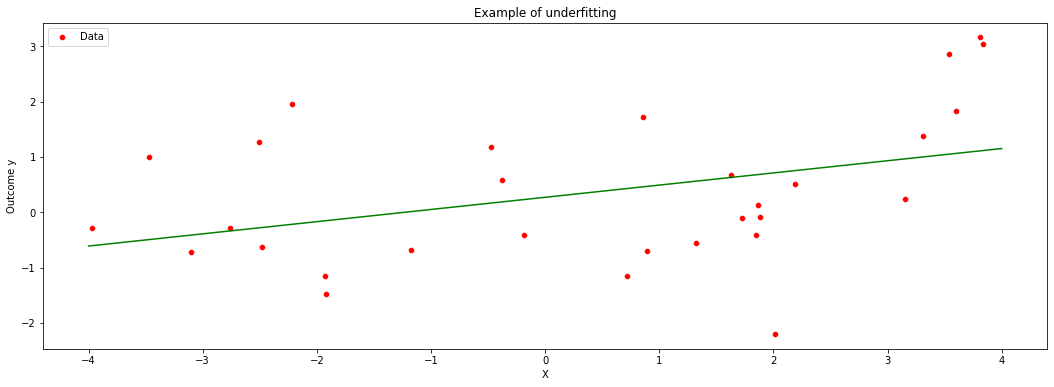

In [504]:
lin = LinearRegression()

lin.fit(X[0:30], Y[0:30])


x = data['x']
xgrid = np.linspace(min(x),max(x), 1000)

new_data = pd.DataFrame(xgrid, columns=['x'])

yhat = lin.predict(new_data)

plt.figure(figsize=(18,6))
sns.scatterplot(data.loc[subset,'x'],data.loc[subset,'y'], color = 'red', label = 'Data')
plt.plot(xgrid, yhat, color = 'green',label = 'Estimate')
plt.title('Example of underfitting')
plt.xlabel('X')
plt.ylabel('Outcome y')


This tension is called the **bias-variance trade-off**: simpler models underfit and have more bias, more complex models overfit and have more variance.

One data-driven way of deciding an appropriate level of complexity is to divide the available data into a training set (where the model is fit) and the validation set (where the model is evaluated). The next snippet of code uses the first half of the data to fit a polynomial of order $q$, and then evaluates that polynomial on the second half. The training MSE estimate decreases monotonically with the polynomial degree, because the model is better able to fit on the training data; the test MSE estimate starts increasing after a while reflecting that the model no longer generalizes well.

In [560]:
degrees =np.arange(3,21)
train_mse =[]
test_mse =[]
for d in degrees:
    poly =PolynomialFeatures(degree = d, include_bias =False  )
    poly_features = poly.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(poly_features,y, train_size=0.5 , random_state= 0)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)

    poly_reg_model = LinearRegression()
    poly_reg_model.fit(X_train, y_train)
    
    
    y_train_pred = poly_reg_model.predict(X_train)
    y_test_pred = poly_reg_model.predict(X_test)

    mse_train= mean_squared_error(y_train, y_train_pred)
    mse_test= mean_squared_error(y_test, y_test_pred)
    
    train_mse.append(mse_train)
    test_mse.append(mse_test)

Text(7, 1.3, 'High bias \n Low Variance')

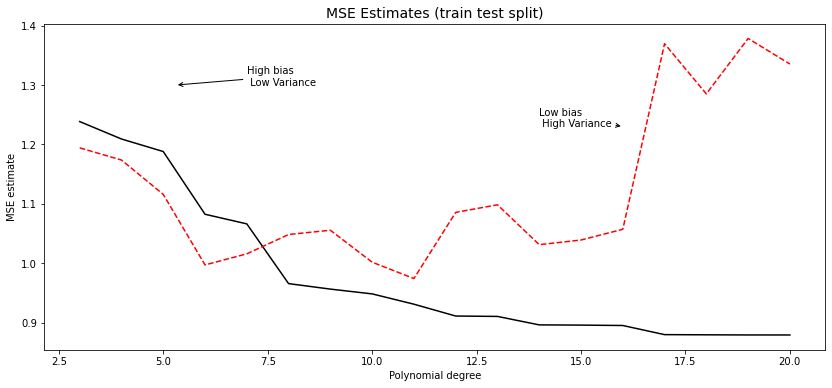

In [606]:
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(degrees, train_mse,color ="black", label = "Training")
ax.plot(degrees, test_mse,"r--", label = "Validation")

ax.set_title("MSE Estimates (train test split)", fontsize =14)
ax.set(xlabel = "Polynomial degree", ylabel = "MSE estimate")
    
ax.annotate("Low bias \n High Variance", xy=(16, 1.23), xycoords='data', xytext=(14, 1.23), textcoords='data',
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3"),)
ax.annotate("High bias \n Low Variance", xy=(5.3, 1.30), xycoords='data', xytext=(7, 1.30), textcoords='data',
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3"),)


To make better use of the data we will often divide the data into $K$ subsets, or _folds_. Then one fits $K$ models, each using  $K-1$ folds and then evaluation the fitted model on the remaining fold. This is called **k-fold cross-validation**.

In [607]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
#cv = KFold(n_splits=10, random_state=1, shuffle=True)
scorer = make_scorer
mse =[]

for d in degrees: 
    
    poly =PolynomialFeatures(degree = d, include_bias =False  )
    poly_features = poly.fit_transform(X)
    ols = LinearRegression()
    scorer = make_scorer(mean_squared_error)
    mse_test= cross_val_score(ols, poly_features, y, scoring=scorer, cv =5).mean()
    mse.append(mse_test)

Text(0.5, 1.0, 'MSE estimate (K-fold cross validation)')

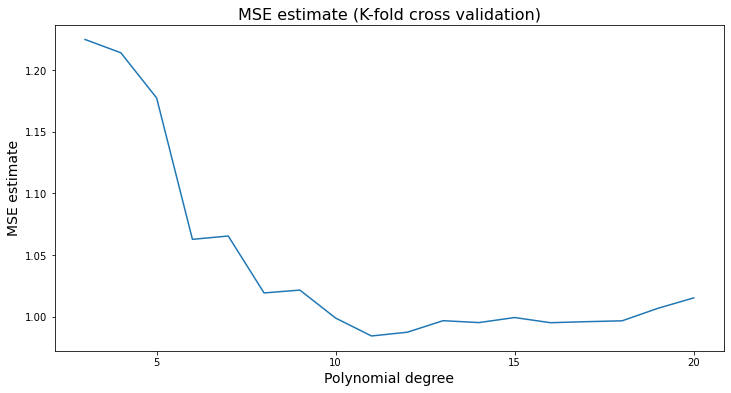

In [608]:
plt.figure(figsize=(12,6))
plt.plot(degrees, mse)
plt.xlabel('Polynomial degree', fontsize = 14)
plt.xticks(np.arange(5,21,5))
plt.ylabel('MSE estimate', fontsize = 14)
plt.title('MSE estimate (K-fold cross validation)', fontsize =16)
#different to r, the models in python got a better performance with more training cause by the
#cross validation and the kfold

A final remark is that, in machine learning applications, the complexity of the model often is allowed to increase with the available data. In the example above, even though we weren’t very successful when fitting a high-dimensional model on very little data, if we had much more data perhaps such a model would be appropriate. The next figure again fits a high order polynomial model, but this time on many data points. Note how, at least in data-rich regions, the model is much better behaved, and tracks the average outcome reasonably well without trying to interpolate wildly of the data points. 

Text(0, 0.5, 'Outcome')

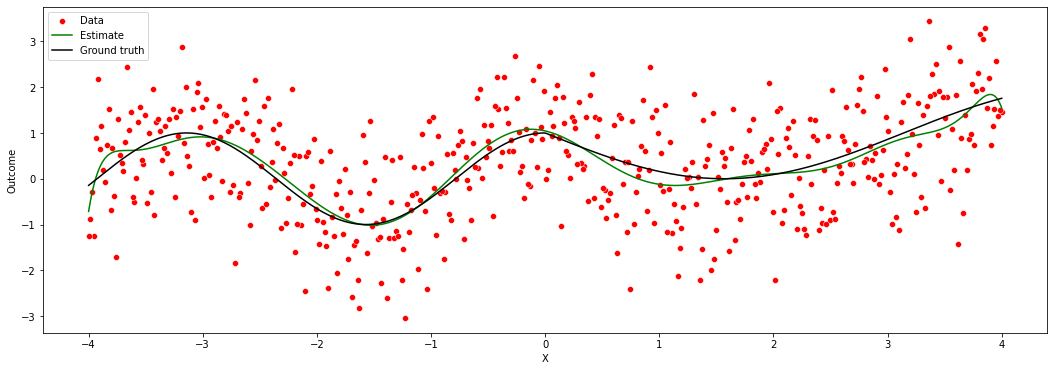

In [609]:
X = data.loc[:,'x'].values.reshape(-1, 1)
Y = data.loc[:,'y'].values.reshape(-1, 1)


subset = np.arange(0,500)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


poly = PolynomialFeatures(degree = 15)
X_poly = poly.fit_transform(X)

poly.fit(X_poly, Y)
lin2 = LinearRegression()
lin2.fit(X_poly[0:500], Y[0:500])

x = data['x']
xgrid = np.linspace(min(x),max(x), 1000)

new_data = pd.DataFrame(xgrid, columns=['x'])

yhat = lin2.predict(poly.fit_transform(new_data))

# Visualising the Polynomial Regression results
plt.figure(figsize=(18,6))
sns.scatterplot(data.loc[subset,'x'],data.loc[subset,'y'], color = 'red', label = 'Data')
plt.plot(xgrid, yhat, color = 'green', label = 'Estimate')
sns.lineplot(x,mu, color = 'black', label = "Ground truth")

plt.xlabel('X')
plt.ylabel('Outcome')

This is one of the benefits of using machine learning-based models: more data implies more flexible modeling, and therefore potentially better predictive power -- provided that we carefully avoid overfitting.

The example above based on polynomial regression was used mostly for illustration. In practice, there are often better-performing algorithms. We’ll see some of them next.

## Common machine learning algorithms


Next, we’ll introduce three machine learning algorithms: (regularized) linear models, trees, and forests. Although this isn't an exhaustive list, these algorithms are common enough that every machine learning practitioner should know about them. They also have convenient `R` packages that allow for easy coding.

In this tutorial, we'll focus heavily on how to **interpret** the output of machine learning models -- or, at least, how not to _mis_-interpret it. However, in this chapter we won’t be making any causal claims about the relationships between variables yet. But please hang tight, as estimating causal effects will be one of the main topics presented in the next chapters.

For the remainder of the chapter we will use a real dataset. Each row in this data set represents the characteristics of a owner-occupied housing unit. Our goal is to predict the (log) price of the housing unit (`LOGVALUE`, our outcome variable) from features such as the size of the lot (`LOT`) and square feet area (`UNITSF`), number of bedrooms (`BEDRMS`) and bathrooms (`BATHS`), year in which it was built (`BUILT`) etc. This dataset comes from the American Housing Survey and was used in [Mullainathan and Spiess (2017, JEP)](https://www.aeaweb.org/articles?id=10.1257/jep.31.2.87). In addition, we will append to this data columns that are pure noise. Ideally, our fitted model should not take them into acccount.

In [3]:
import requests
import io

url = 'https://docs.google.com/uc?id=1qHr-6nN7pCbU8JUtbRDtMzUKqS9ZlZcR&export=download'
urlData = requests.get(url).content
data = pd.read_csv(io.StringIO(urlData.decode('utf-8')))
data.drop(['Unnamed: 0'], axis=1, inplace=True)

# outcome variable name
outcome = 'LOGVALUE'

# covariates
true_covariates = ['LOT','UNITSF','BUILT','BATHS','BEDRMS','DINING','METRO','CRACKS','REGION','METRO3','PHONE','KITCHEN','MOBILTYP','WINTEROVEN','WINTERKESP','WINTERELSP','WINTERWOOD','WINTERNONE','NEWC','DISH','WASH','DRY','NUNIT2','BURNER','COOK','OVEN','REFR','DENS','FAMRM','HALFB','KITCH','LIVING','OTHFN','RECRM','CLIMB','ELEV','DIRAC','PORCH','AIRSYS','WELL','WELDUS','STEAM','OARSYS']
p_true = len(true_covariates)

# noise covariates added for didactic reasons

p_noise = 20

noise_covariates = []
for x in range(1, p_noise+1):
    noise_covariates.append('noise{0}'.format(x))

covariates = true_covariates + noise_covariates

x_noise = np.random.rand(data.shape[0] * p_noise).reshape(28727,20)
x_noise = pd.DataFrame(x_noise, columns=noise_covariates)
data = pd.concat([data, x_noise], axis=1)

# sample size
n = data.shape[0]

# total number of covariates
p = len(covariates)

Here's the correlation between the first few covariates. Note how, most variables are positively correlated, which is expected since houses with more bedrooms will usually also have more bathrooms, larger area, etc.

In [3]:
data.loc[:,covariates[0:8]].corr()

,LOT,UNITSF,BUILT,BATHS,BEDRMS,DINING,METRO,CRACKS
LOT,1.000000,0.064841,0.044639,0.057325,0.009626,-0.015348,0.136258,0.016851
UNITSF,0.064841,1.000000,0.143201,0.428723,0.361165,0.214030,0.057441,0.033548
BUILT,0.044639,0.143201,1.000000,0.434519,0.215109,0.037468,0.323703,0.092390
BATHS,0.057325,0.428723,0.434519,1.000000,0.540230,0.259457,0.189812,0.062819
BEDRMS,0.009626,0.361165,0.215109,0.540230,1.000000,0.281846,0.121331,0.026779
DINING,-0.015348,0.214030,0.037468,0.259457,0.281846,1.000000,0.022026,0.021270
METRO,0.136258,0.057441,0.323703,0.189812,0.121331,0.022026,1.000000,0.057545
CRACKS,0.016851,0.033548,0.092390,0.062819,0.026779,0.021270,0.057545,1.000000


### Generalized linear models

This class of models extends common methods such as linear and logistic regression by adding a penalty to the magnitude of the coefficients. **Lasso** penalizes the absolute value of slope coefficients. For regression problems, it becomes

$$
  \hat{b}_{Lasso} = \arg\min_b \sum_{i=1}^m
    \left( Y_i - b_0 - X_{i1}b_1 - \cdots - X_{ip}b_p \right)^2
    - \lambda \sum_{j=1}^p |b_j|
$$ (lasso)


Similarly, in a regression problem **Ridge** penalizes the sum of squares of the slope coefficients,

$$
  \hat{b}_{Ridge} = \arg\min_b \sum_{i=1}^m
    \left( Y_i - b_0 - X_{i1}b_1 - \cdots - X_{ip}b_p \right)^2
    - \lambda \sum_{j=1}^p b_j^2
$$ (ridge)

Also, there exists the **Elastic Net** penalization which consists of a convex combination between the other two. In all cases, the scalar parameter
$\lambda$ controls the complexity of the model. For $\lambda=0$, the problem reduces to the “usual” linear regression. As $\lambda$ increases, we favor simpler models. As we’ll see below, the optimal parameter $\lambda$ is selected via cross-validation.

An important feature of Lasso-type penalization is that it promotes **sparsity** – that is, it forces many coefficients to be exactly zero. This is different from Ridge-type penalization, which forces coefficients to be small.

Another interesting property of these models is that, even though they are called “linear” models, this should actually be understood as **linear in transformations** of the covariates. For example, we could use polynomials or splines (continuous piecewise polynomials) of the covariates and allow for much more flexible models.

In fact, because of the penalization term, problems {eq}`lasso` and {eq}`ridge` remain well-defined and have a unique solution even in **high-dimensional** problems in which the number of coefficients $p$ is larger than the sample size $n$ – that is, our data is “fat” with more columns than rows. These situations can arise either naturally (e.g. genomics problems in which we have hundreds of thousands of gene expression information for a few individuals) or because we are including many transformations of a smaller set of covariates.

Finally, although here we are focusing on regression problems, other generalized linear models such as logistic regression can also be similarly modified by adding a Lasso, Ridge, or Elastic Net-type penalty to similar consequences.


In [8]:
X = data.loc[:,covariates]
Y = data.loc[:,outcome]

In [36]:
from sklearn.linear_model import Lasso

lasso = Lasso()
alphas = np.logspace(np.log10(1e-8), np.log10(1e-1), 100)

tuned_parameters = [{"alpha": alphas}]
n_folds = 10

scorer = make_scorer(mean_squared_error)

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False, scoring=scorer)
clf.fit(X, Y)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]


The next figure plots the average estimated MSE for each lambda. The red dots are the averages across all folds, and the error bars are based on the variability of mse estimates across folds. The vertical dashed lines show the (log) lambda with smallest estimated MSE (left) and the one whose mse is at most one standard error from the first (right).

In [37]:
data_lasso = pd.DataFrame([pd.Series(alphas, name= "alphas"), pd.Series(scores, name = "scores")]).T
best = data_lasso[data_lasso["scores"] == np.min(data_lasso["scores"])]

(1e-08, 0.1)

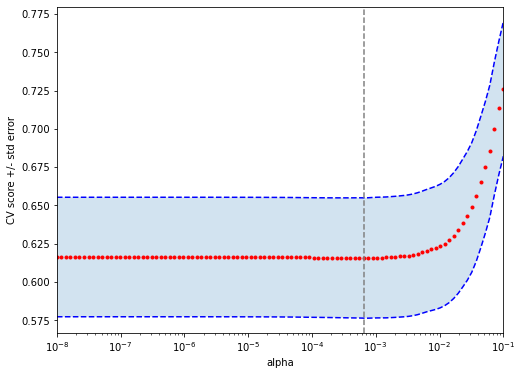

In [38]:
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores, ".", color = "red")

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, "b--")
plt.semilogx(alphas, scores - std_error, "b--")

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel("CV score +/- std error")
plt.xlabel("alpha")
plt.axvline(best.iloc[0,0], linestyle="--", color=".5")
plt.xlim([alphas[0], alphas[-1]])

Here are the first few estimated coefficients at the $\lambda$ value that minimizes cross-validated MSE. Note that many estimated coefficients them are exactly zero.

In [39]:
lasso = Lasso(alpha=best.iloc[0,0])
lasso.fit(X,Y)
table = np.zeros((1,5))
table[0,0] = lasso.intercept_
table[0,1] = lasso.coef_[0]
table[0,2] = lasso.coef_[1]
table[0,3] = lasso.coef_[2]
table[0,4] = lasso.coef_[3]
pd.DataFrame(table, columns=['(Intercept)','LOT','UNITSF','BUILT','BATHS'], index=['Coef.'])

,(Intercept),LOT,UNITSF,BUILT,BATHS
Coef.,11.643421,3.494443e-07,0.000023,0.000229,0.246402


In [40]:
print("Number of nonzero coefficients at optimal lambda:", len(lasso.coef_[lasso.coef_ != 0]), "out of " , len(lasso.coef_)) 

Number of nonzero coefficients at optimal lambda: 46 out of  63


Predictions and estimated MSE for the selected model are retrieved as follows.


In [41]:
# Retrieve predictions at best lambda regularization parameter
y_hat = lasso.predict(X)

# Get k-fold cross validation
mse_lasso  = best.iloc[0,1]

print("glmnet MSE estimate (k-fold cross-validation):", mse_lasso)

glmnet MSE estimate (k-fold cross-validation): 0.6156670911339063


The next command plots estimated coefficients as a function of the regularization parameter $\lambda$.


In [42]:
coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X, Y)
    coefs.append(lasso.coef_)

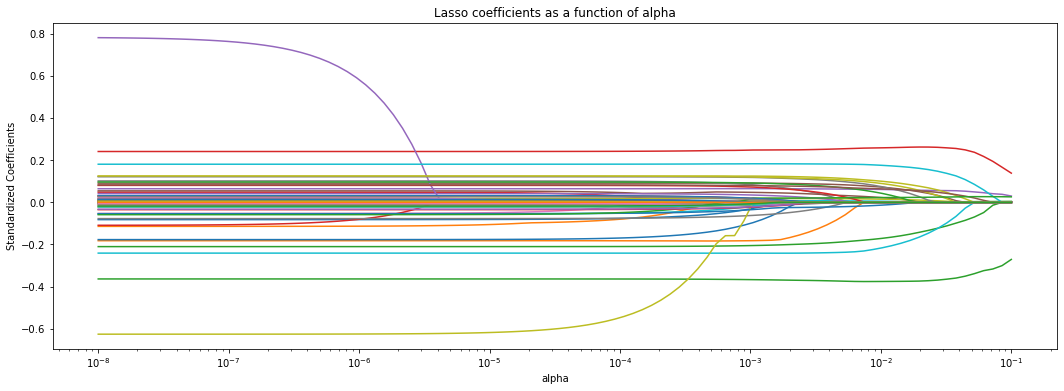

In [43]:
from matplotlib.pyplot import figure

plt.figure(figsize=(18,6))
plt.gca().plot(alphas, coefs)
plt.gca().set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');



It's tempting to try to interpret the coefficients obtained via Lasso. Unfortunately, that can be very difficult, because by dropping covariates Lasso introduces a form of **omitted variable bias** ([wikipedia](https://en.wikipedia.org/wiki/Omitted-variable_bias)). To understand this form of bias, consider the following toy example. We have two positively correlated independent variables, `x.1` and `x.2`, that are linearly related to the outcome `y`. Linear regression of `y` on `x1` and `x2` gives us the correct coefficients. However, if we _omit_ `x2` from the estimation model, the coefficient on `x1` increases. This is because `x1` is now "picking up" the effect of the variable that was left out. In other words, the effect of `x1` seems stronger because we aren't controlling for some other confounding variable. Note that the second model this still works for prediction, but we cannot interpret the coefficient as a measure of strength of the causal relationship between `x1` and `y`.

In [44]:
mean = [0.0,0.0]
cov = [[1.5,1],[1,1.5]]

x1, x2 = np.random.multivariate_normal(mean, cov, 100000).T
y = 1 + 2*x1 + 3*x2 + np.random.rand(100000)
data_sim = pd.DataFrame(np.array([x1,x2,y]).T,columns=['x1','x2','y'] )

print('Correct Model')

Correct Model


In [45]:
import statsmodels.formula.api as smf

result = smf.ols('y ~ x1 + x2', data = data_sim).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.897e+07
Date:                Wed, 22 Jun 2022   Prob (F-statistic):               0.00
Time:                        20:59:12   Log-Likelihood:                -17706.
No. Observations:              100000   AIC:                         3.542e+04
Df Residuals:                   99997   BIC:                         3.545e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5012      0.001   1643.500      0.0

In [46]:
print("Model with omitted variable bias")

result = smf.ols('y ~ x1', data = data_sim).fit()
print(result.summary())

Model with omitted variable bias
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                 3.174e+05
Date:                Wed, 22 Jun 2022   Prob (F-statistic):               0.00
Time:                        20:59:21   Log-Likelihood:            -2.4332e+05
No. Observations:              100000   AIC:                         4.866e+05
Df Residuals:                   99998   BIC:                         4.867e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.51


The phenomenon above occurs in Lasso and in any other sparsity-promoting method when correlated covariates are present since, by forcing coefficients to be zero, Lasso is effectively dropping them from the model. And as we have seen, as a variable gets dropped, a different variable that is correlated with it can "pick up" its effect, which in turn can cause bias. Once $\lambda$ grows sufficiently large, the penalization term overwhelms any benefit of having that variable in the model, so that variable finally decreases to zero too.

One may instead consider using Lasso to select a subset of variables, and then regressing the outcome on the subset of selected variables via OLS (without any penalization). This method is often called **post-lasso**. Although it has desirable properties in terms of model fit (see e.g., [Belloni and Chernozhukov, 2013](https://arxiv.org/pdf/1001.0188.pdf)), this procedure does not solve the omitted variable issue we mentioned above.

We illustrate this next. We observe the path of the estimated coefficient on the number of bathroooms (`BATHS`) as we increase $\lambda$.

Text(0.5, 0, 'lambda')

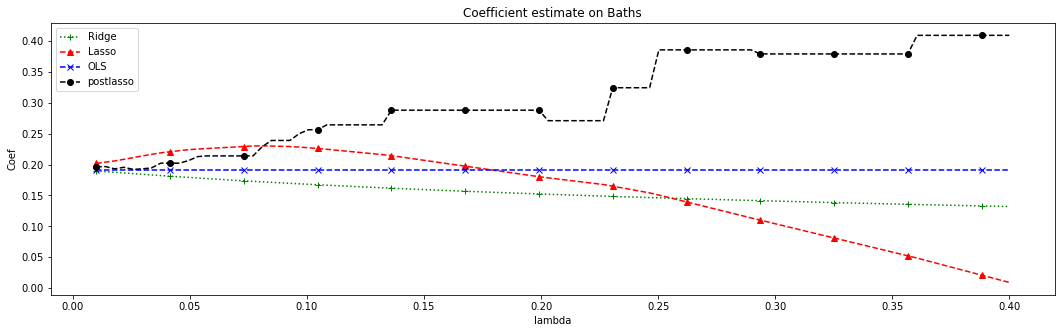

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

scale_X = StandardScaler().fit(X).transform(X)
ols = LinearRegression()
ols.fit(scale_X,Y)
ols_coef = ols.coef_[3]
lamdas = np.linspace(0.01,0.4, 100)


coef_ols = np.repeat(ols_coef,100)
###############################################

lasso_bath_coef = []
lasso_coefs=[]
for a in lamdas:
    lasso.set_params(alpha=a,normalize = False)
    lasso.fit(scale_X, Y)
    lasso_bath_coef.append(lasso.coef_[3])
    lasso_coefs.append(lasso.coef_)
#################################################   

ridge_bath_coef = []
for a in lamdas:
    ridge = Ridge(alpha=a,normalize = True)
    ridge.fit(scale_X, Y)
    ridge_bath_coef.append(ridge.coef_[3])
####################################################

poslasso_coef = [ ]
for a in range(100):
    scale_X = StandardScaler().fit(X.iloc[:, (lasso_coefs[a] !=  0)]).transform(X.iloc[:, (lasso_coefs[a] !=  0)])
    ols = LinearRegression()
    ols.fit(scale_X,Y)  
    post_coef = ols.coef_[X.iloc[:, (lasso_coefs[a] !=  0)].columns.get_loc('BATHS')]                             
    poslasso_coef.append(post_coef )    
    
    
#################################################
plt.figure(figsize=(18,5))
plt.plot(lamdas, ridge_bath_coef, label = 'Ridge', color = 'g', marker='+', linestyle = ':',markevery=8)
plt.plot(lamdas, lasso_bath_coef, label = 'Lasso', color = 'r', marker = '^',linestyle = 'dashed',markevery=8)
plt.plot(lamdas, coef_ols, label = 'OLS', color = 'b',marker = 'x',linestyle = 'dashed',markevery=8)
plt.plot(lamdas, poslasso_coef, label = 'postlasso',color='black',marker = 'o',linestyle = 'dashed',markevery=8 )
plt.legend()
plt.title("Coefficient estimate on Baths")
plt.ylabel('Coef')
plt.xlabel('lambda')


The OLS coefficients are not penalized, so they remain constant. Ridge estimates decrease monotonically as $\lambda$ grows. Also, for this dataset, Lasso estimates first increase and then decrease. Meanwhile, the post-lasso coefficient estimates seem to behave somewhat erratically with $lambda$. To understand this behavior, let's see what happens to the magnitude of other selected variables that are correlated with `BATHS`. 

In [49]:
scale_X = StandardScaler().fit(X).transform(X)
UNITSF_coef = []
BEDRMS_coef = []
DINING_coef = []
for a in lamdas:
    lasso.set_params(alpha=a,normalize = False)
    lasso.fit(scale_X, Y)
    UNITSF_coef.append(lasso.coef_[1])
    BEDRMS_coef.append(lasso.coef_[4])
    DINING_coef.append(lasso.coef_[5])

Text(0.5, 0, 'lambda')

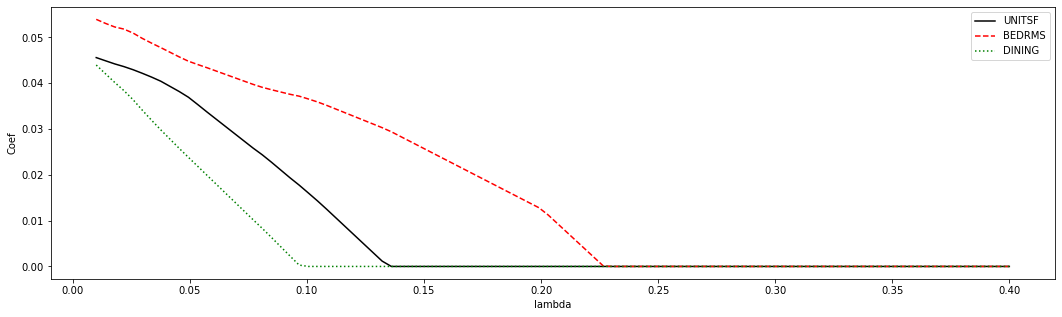

In [50]:
plt.figure(figsize=(18,5))
plt.plot(lamdas, UNITSF_coef,label = 'UNITSF', color = 'black' )
plt.plot(lamdas, BEDRMS_coef,label = 'BEDRMS', color = 'red',  linestyle = '--')
plt.plot(lamdas, DINING_coef,label = 'DINING', color = 'g',linestyle = 'dotted')
plt.legend()
plt.ylabel('Coef')
plt.xlabel('lambda')

Note how the discrete jumps in magnitude for the `BATHS` coefficient in the first coincide with, for example, variables `DINING` and `BEDRMS` being exactly zero. As these variables got dropped from the model, the coefficient on `BATHS` increased to pick up their effect. 

Another problem with Lasso coefficients is their instability. When multiple variables are highly correlated we may spuriously drop several of them. To get a sense of the amount of variability, in the next snippet we fix $\lambda$ and then look at the lasso coefficients estimated during cross-validation. We see that by simply removing one fold we can get a very different set of coefficients (nonzero coefficients are in black in the heatmap below). This is because there may be many choices of coefficients with similar predictive power, so the set of nonzero coefficients we end up with can be quite unstable.

In [70]:
import itertools
nobs = X.shape[0]

nfold = 10
    # Define folds indices 
list_1 = [*range(0, nfold, 1)]*nobs
sample = np.random.choice(nobs,nobs, replace=False).tolist()
foldid = [list_1[index] for index in sample]

    # Create split function(similar to R)
def split(x, f):
    count = max(f) + 1
    return tuple( list(itertools.compress(x, (el == i for el in f))) for i in range(count) ) 

    # Split observation indices into folds 
list_2 = [*range(0, nobs, 1)]
I = split(list_2, foldid)

In [71]:
from sklearn.linear_model import LassoCV

scale_X = StandardScaler().fit(X).transform(X)
lasso_coef_fold=[]
for b in range(0,len(I)):
    
        # Split data - index to keep are in mask as booleans
        include_idx = set(I[b])  #Here should go I[b] Set is more efficient, but doesn't reorder your elements if that is desireable
        mask = np.array([(i in include_idx) for i in range(len(X))])

        # Lasso regression, excluding folds selected 
        
        lassocv = LassoCV(random_state=0)
        lassocv.fit(scale_X[~mask], Y[~mask])
        lasso_coef_fold.append(lassocv.coef_)
       

In [72]:
index_val = ['Fold-1','Fold-2','Fold-3','Fold-4','Fold-5','Fold-6','Fold-7','Fold-8','Fold-9','Fold-10']
df = pd.DataFrame(data= lasso_coef_fold, columns=X.columns, index = index_val).T
df.style.applymap(lambda x: "background-color: white" if x==0 else "background-color: black")

,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5,Fold-6,Fold-7,Fold-8,Fold-9,Fold-10
LOT,0.041050,0.040789,0.039105,0.037300,0.041148,0.043150,0.037104,0.035392,0.037300,0.037464
UNITSF,0.044746,0.046055,0.047095,0.045291,0.049540,0.043839,0.043077,0.051535,0.047132,0.046415
BUILT,0.001111,0.004845,0.003385,0.003564,0.004757,0.003220,0.003449,0.002987,0.000929,0.004401
BATHS,0.200578,0.189623,0.195828,0.200489,0.192490,0.198082,0.203624,0.200081,0.198007,0.198827
BEDRMS,0.055605,0.057472,0.055982,0.055394,0.054981,0.056335,0.054475,0.049082,0.055994,0.052763
DINING,0.047736,0.046748,0.047269,0.044850,0.044751,0.046515,0.044934,0.048129,0.046415,0.046481
METRO,0.000000,0.000356,0.000000,0.001081,0.001190,0.000881,0.000000,0.003189,0.001222,0.002415
CRACKS,0.020332,0.020937,0.017848,0.015932,0.019917,0.019677,0.018395,0.023793,0.020314,0.019614
REGION,0.083864,0.083337,0.080464,0.081884,0.081064,0.082150,0.078420,0.082237,0.082466,0.082625
METRO3,0.007152,0.006738,0.009395,0.009017,0.010476,0.010692,0.007217,0.008143,0.008373,0.007819


As we have seen above, any interpretation needs to take into account the joint distribution of covariates. One possible heuristic is to consider **data-driven subgroups**. For example, we can analyze what differentiates observations whose predictions are high from those whose predictions are low. The following code estimates a flexible Lasso model with splines, ranks the observations into a few subgroups according to their predicted outcomes, and then estimates the average covariate value for each subgroup.  

In [124]:
import itertools
nobs = X.shape[0]

nfold = 5
    # Define folds indices 
list_1 = [*range(0, nfold, 1)]*nobs
sample = np.random.choice(nobs,nobs, replace=False).tolist()
foldid = [list_1[index] for index in sample]

    # Create split function(similar to R)
def split(x, f):
    count = max(f) + 1
    return tuple( list(itertools.compress(x, (el == i for el in f))) for i in range(count) ) 

    # Split observation indices into folds 
list_2 = [*range(0, nobs, 1)]
I = split(list_2, foldid)


lasso_coef_rank=[]
lasso_pred = []
for b in range(0,len(I)):
        # Split data - index to keep are in mask as booleans
        include_idx = set(I[b])  #Here should go I[b] Set is more efficient, but doesn't reorder your elements if that is desireable
        mask = np.array([(i in include_idx) for i in range(len(X))])

        # Lasso regression, excluding folds selected 
        
        lassocv = LassoCV(random_state=0)
        lassocv.fit(scale_X[~mask], Y[~mask])
        lasso_coef_rank.append(lassocv.coef_)
        lasso_pred.append(lassocv.predict(scale_X[mask]))

In [125]:
y_hat = lasso_pred

df_1 = pd.DataFrame()
for i in [0,1,2,3,4]:
    df_2 = pd.DataFrame(y_hat[i])
    
    b =pd.cut(df_2[0], bins =[np.percentile(df_2,0),np.percentile(df_2,25),np.percentile(df_2,50),
           np.percentile(df_2,75),np.percentile(df_2,100)], labels = [1,2,3,4])
    
    df_1 = pd.concat([df_1, b])
df_1 =df_1.apply(lambda x: pd.factorize(x)[0])
df_1.rename(columns={0:'ranking'}, inplace=True)
df_1 =df_1.reset_index().drop(columns=['index'])

In [126]:
import statsmodels.api as sm
from scipy.stats import norm
import statsmodels.formula.api as smf

In [127]:
y = X
x = df_1
y = pd.DataFrame(y)
x = pd.DataFrame(x)
y['ranking'] = x
data = y

In [128]:
data_frame = pd.DataFrame()
for var_name in covariates:
    form = var_name + " ~ " + "0" + "+" + "C(ranking)"
    df1 = smf.ols(formula=form, data=data).fit(cov_type = 'HC2').summary2().tables[1].iloc[1:5, :2] #iloc to stay with rankings 0,1,2,3
    df1.insert(0, 'covariate', var_name)
    df1.insert(3, 'ranking', ['G1','G2','G3','G4'])
    df1.insert(4, 'scaling',
               pd.DataFrame(norm.cdf((df1['Coef.'] - np.mean(df1['Coef.']))/np.std(df1['Coef.']))))
    df1.insert(5, 'variation',
               np.std(df1['Coef.'])/np.std(data[var_name]))
    label = []
    for j in range(0,4):
        label += [str(round(df1['Coef.'][j],3)) + " (" 
                  + str(round(df1['Std.Err.'][j],3)) + ")"]
    df1.insert(6, 'labels', label)
    df1.reset_index().drop(columns=['index'])
    index = []
    for m in range(0,4):
        index += [str(df1['covariate'][m]) + "_" + "ranking" + str(m+1)]
    idx = pd.Index(index)
    df1 = df1.set_index(idx)
    data_frame = data_frame.append(df1)
data_frame;

In [129]:
labels_data = pd.DataFrame()
for i in range(1,5):
    df_mask = data_frame['ranking']==f"G{i}"
    filtered_df = data_frame[df_mask].reset_index().drop(columns=['index'])
    labels_data[f"ranking{i}"] = filtered_df[['labels']]
labels_data = labels_data.set_index(pd.Index(covariates))
labels_data

,ranking1,ranking2,ranking3,ranking4
LOT,49713.31 (1473.048),46479.968 (1390.394),47806.63 (1427.658),47612.513 (1393.569)
UNITSF,2415.869 (24.944),2434.834 (24.249),2397.706 (23.467),2471.907 (26.208)
BUILT,1972.286 (0.301),1974.925 (0.294),1973.672 (0.299),1973.017 (0.299)
BATHS,1.918 (0.009),1.975 (0.009),1.946 (0.009),1.928 (0.009)
BEDRMS,3.218 (0.01),3.258 (0.01),3.251 (0.01),3.243 (0.01)
...,...,...,...,...
noise16,0.499 (0.003),0.502 (0.003),0.498 (0.003),0.505 (0.003)
noise17,0.501 (0.003),0.498 (0.003),0.502 (0.003),0.498 (0.003)
noise18,0.502 (0.003),0.499 (0.003),0.5 (0.003),0.5 (0.003)
noise19,0.504 (0.003),0.502 (0.003),0.498 (0.003),0.497 (0.003)


The next heatmap visualizes the results. Note how observations ranked higher (i.e., were predicted to have higher prices) have more bedrooms and baths, were built more recently, have fewer cracks, and so on. The next snippet of code displays the average covariate per group along with each standard errors. The rows are ordered according to $Var(E[X_{ij} | G_i) / Var(X_i)$, where $G_i$ denotes the ranking. This is a rough normalized measure of how much variation is "explained" by group membership $G_i$. Brighter colors indicate larger values.

In [130]:
new_data = pd.DataFrame()
for i in range(0,4):
    df_mask = data_frame['ranking']==f"G{i+1}"
    filtered_df = data_frame[df_mask]
    new_data.insert(i,f"G{i+1}",filtered_df[['scaling']])
new_data;

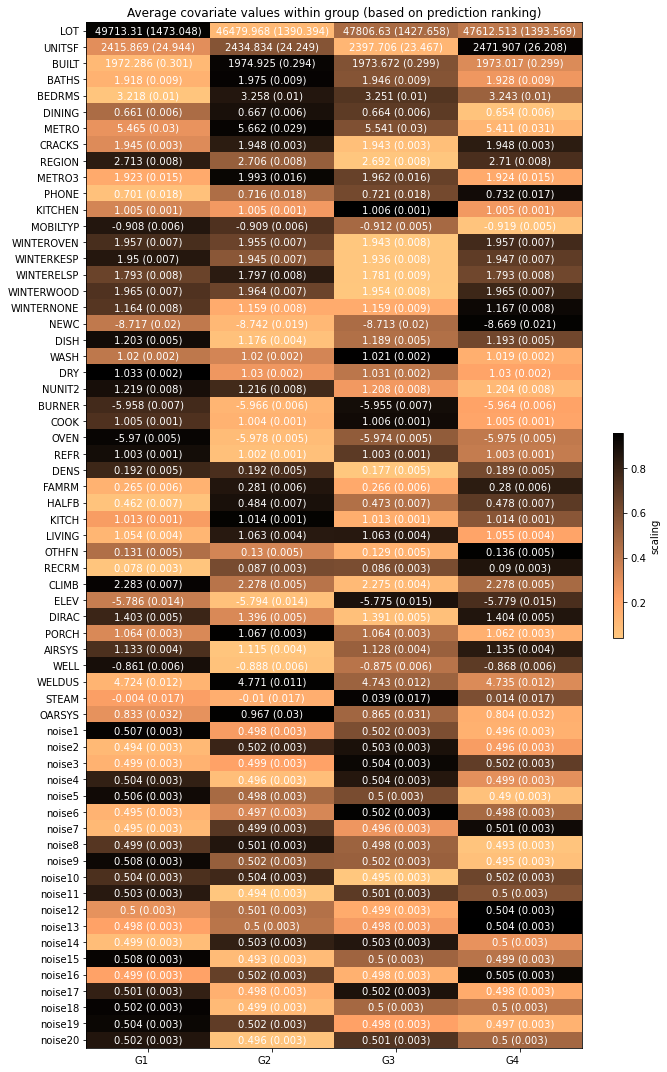

In [131]:
features = covariates
ranks = ['G1','G2','G3','G4']
harvest =  np.array(round(new_data,3))
labels_hm = np.array(round(labels_data))

fig, ax = plt.subplots(figsize=(10,15))

# getting the original colormap using cm.get_cmap() function
orig_map = plt.cm.get_cmap('copper')
  
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()
im = ax.imshow(harvest, cmap=reversed_map, aspect='auto')

# make bar
bar = plt.colorbar(im, shrink=0.2)
  
# show plot with labels
bar.set_label('scaling')

 
# Setting the labels
ax.set_xticks(np.arange(len(ranks)))
ax.set_yticks(np.arange(len(features)))
# labeling respective list entries
ax.set_xticklabels(ranks)
ax.set_yticklabels(features)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), ha="right",
         rotation_mode="anchor")

# Creating text annotations by using for loop
for i in range(len(features)):
    for j in range(len(ranks)):
        text = ax.text(j, i, labels_hm[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Average covariate values within group (based on prediction ranking)")
fig.tight_layout()


plt.show()


As we just saw above, houses that have, e.g., been built more recently (`BUILT`), have more baths (`BATHS`) are associated with larger price predictions.

This sort of interpretation exercise did not rely on reading any coefficients, and in fact it could also be done using any other flexible method, including decisions trees and forests.

### Decision Tree


This next class of algorithms divides the covariate space into "regions" and estimates a constant prediction within each region.

To estimate a decision tree, we following a recursive partition algorithm. At each stage, we select one variable $j$ and one split point
$s$, and divide the observations into “left” and “right” subsets, depending on whether $X_{ij} \leq s$ or $X_{ij} > s$. For regression problems, the variable and split points are often selected so that the sum of the variances of the outcome variable in each “child” subset is smallest. For classification problems, we split to separate the classes. Then, for each child, we separately repeat the process of finding variables and split points. This continues until a minimum subset size is reached, or improvement falls below some threshold.

At prediction time, to find the predictions for some point $x$, we just follow the tree we just built, going left or right according to the selected variables and split points, until we reach a terminal node. Then, for regression problems, the predicted value at some point $x$ is the average outcome of the observations in the same partition as the point $x$. For classification problems, we output the majority class in the node.


In [4]:
from sklearn.tree import DecisionTreeRegressor
import graphviz
from sklearn import tree
from sklearn.tree import export_graphviz 
from sklearn.metrics import accuracy_score
from pandas import Series
from simple_colors import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split

In [5]:
#Here we define our X and Y variable
Y = data.loc[:,outcome]
XX = data.loc[:,covariates]

In [6]:
# we split data in train and test
x_train, x_test, y_train, y_test = train_test_split(XX.to_numpy(), Y, test_size=.3)

In [7]:
dt = DecisionTreeRegressor( max_depth=15, random_state=0)
#x_train, x_test, y_train, y_test = train_test_split(XX.to_numpy(), Y, test_size=.3)
tree1 = dt.fit(x_train,y_train)

At this point, we have not constrained the complexity of the tree in any way, so it's likely too deep and probably overfits. Here’s a plot of what we have so far (without bothering to label the splits to avoid clutter).

[Text(0.6937715956946345, 0.96875, 'X[12] <= 0.0\nsquared_error = 0.981\nsamples = 20108\nvalue = 11.814'),
 Text(0.45393733459285945, 0.90625, 'X[1] <= 2436.5\nsquared_error = 0.774\nsamples = 19386\nvalue = 11.889'),
 Text(0.23878549020890355, 0.84375, 'X[3] <= 1.5\nsquared_error = 0.631\nsamples = 13895\nvalue = 11.687'),
 Text(0.11155233658026083, 0.78125, 'X[19] <= 1.5\nsquared_error = 0.705\nsamples = 5094\nvalue = 11.392'),
 Text(0.05217431774271454, 0.71875, 'X[29] <= 0.5\nsquared_error = 0.677\nsamples = 2626\nvalue = 11.544'),
 Text(0.02204757687972951, 0.65625, 'X[14] <= -3.0\nsquared_error = 0.82\nsamples = 1133\nvalue = 11.421'),
 Text(0.0019320560296248591, 0.59375, 'X[47] <= 0.904\nsquared_error = 15.873\nsamples = 7\nvalue = 9.561'),
 Text(0.0016100466913540493, 0.53125, 'X[30] <= 1.5\nsquared_error = 0.743\nsamples = 6\nvalue = 11.155'),
 Text(0.0012880373530832394, 0.46875, 'X[44] <= 0.392\nsquared_error = 0.256\nsamples = 5\nvalue = 10.829'),
 Text(0.0006440186765416

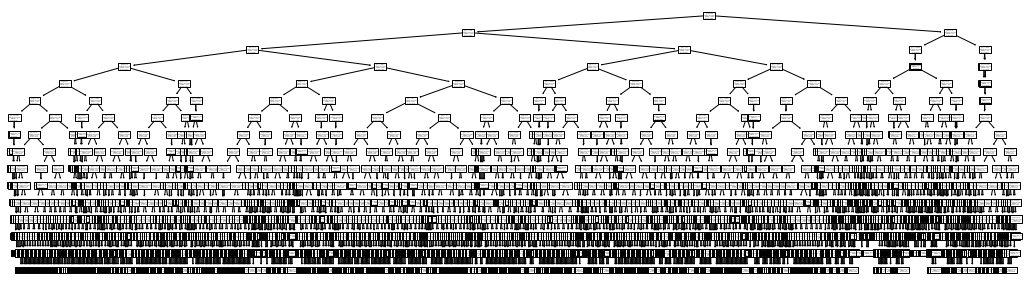

In [7]:
from sklearn import tree
plt.figure(figsize=(18,5))
tree.plot_tree(dt);


To reduce the complexity of the tree, we **prune** the tree: we collapse its leaves, permitting bias to increase but forcing variance to decrease until the desired trade-off is achieved. In `rpart`, this is done by considering a modified loss function that takes into account the number of terminal nodes (i.e., the number of regions in which the original data was partitioned). Somewhat heuristically, if we denote tree predictions by $T(x)$ and its number of terminal nodes by  $|T|$, the modified regression problem can be written as:

$$
  \widehat{T} = \arg\min_{T} \sum_{i=1}^m \left( T(X_i) - Y_i \right)^2 + c_p |T|
$$ (pruned-tree)

The complexity of the tree is controlled by the scalar parameter $c_p$, denoted as `ccp_alpha` in `sklearn.tree.DecisionTreeRegressor`. For each value of $c_p$, we find the subtree that solves {eq}`pruned-tree`. Large values of $c_p$ lead to aggressively pruned trees, which have more bias and less variance. Small values of $c_p$ allow for deeper trees whose predictions can vary more wildly.

In [8]:
import itertools
path = dt.cost_complexity_pruning_path(x_train,y_train)
alphas_dt = pd.Series(path['ccp_alphas'], name = "alphas").unique()

In [56]:
# A function with a manual cross validation
#This function can replicate cp_table that R's rplot package creates to get the best complexity parameter
#This function can be used to prune the tree but it is a lar process, so if you have the computational power, you can use this function
'''
def run_cross_validation_on_trees2(X, y, tree_ccp, nfold=10):

    cp_table_error = []
    cp_table_std = []
    cp_table_rel_error = []
    cp_table_size = []
   
     # Num ob observations
    nobs = y.shape[0]
    
    # Define folds indices 
    list_1 = [*range(0, nfold, 1)]*nobs
    sample = np.random.choice(nobs,nobs, replace=False).tolist()
    foldid = [list_1[index] for index in sample]

    # Create split function(similar to R)
    def split(x, f):
        count = max(f) + 1
        return tuple( list(itertools.compress(x, (el == i for el in f))) for i in range(count) ) 

    # Split observation indices into folds 
    list_2 = [*range(0, nobs, 1)]
    I = split(list_2, foldid)
    
    for i in tree_ccp:
        cv_error_list = []
        cv_rel_error_list = []
        
        dtree = DecisionTreeRegressor( ccp_alpha= i, random_state = 0)
        
    # loop to save results
        for b in range(0,len(I)):
            
            # Split data - index to keep are in mask as booleans
            include_idx = set(I[b])  #Here should go I[b] Set is more efficient, but doesn't reorder your elements if that is desireable
            mask = np.array([(a in include_idx) for a in range(len(y))])
            
            dtree.fit(X[~mask], Y[~mask])
            pred = dtree.predict(X[mask])
            xerror_fold = np.mean(np.power(pred - y[mask],2))
            rel_error_fold = 1- r2_score(y[mask], pred)
            
            cv_error_list.append(xerror_fold)
            cv_rel_error_list.append(rel_error_fold)
            
        rel_error = np.mean(cv_rel_error_list)
        xerror = np.mean(cv_error_list)
        xstd = np.std(cv_error_list)

        cp_table_rel_error.append(rel_error)
        cp_table_error.append(xerror)
        cp_table_std.append(xstd)
        cp_table_size.append(dtree.tree_.node_count)
    cp_table = pd.DataFrame([pd.Series(tree_ccp, name = "cp"), pd.Series(cp_table_size, name = "size")
                        , pd.Series(cp_table_rel_error, name = "rel error"),
                         pd.Series(cp_table_error, name = "xerror"),
                         pd.Series(cp_table_std, name = "xstd")]).T    
    return cp_table
'''

In [13]:
#Here we create a loop to get an arrange with all Mean Squared Errors for each cp_alpha
from sklearn.metrics import mean_squared_error
mse_gini = []
cp_table_size = []
for i in alphas_dt:
    dtree = DecisionTreeRegressor( ccp_alpha=i, random_state = 0)
    dtree.fit(x_train, y_train)
    pred = dtree.predict(x_test)
    mse_gini.append(mean_squared_error(y_test, pred))
    cp_table_size.append(dtree.tree_.node_count)

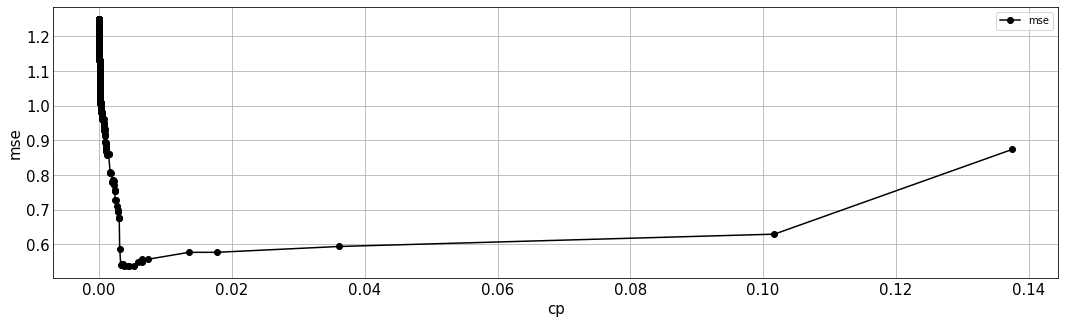

In [123]:
d2 = pd.DataFrame({'acc_gini':pd.Series(mse_gini),'ccp_alphas':pd.Series(alphas_dt)})

#plt.style.context("dark_background")

# visualizing changes in parameters
plt.figure(figsize=(18,5), facecolor = "white")
plt.plot('ccp_alphas','acc_gini', data=d2, label='mse', marker="o", color='black')
#plt.gca().invert_xaxis()


#plt.xticks(np.arange(0, 0.15, step=0.01))  # Set label locations.
#plt.yticks(np.arange(0.5, 1.5, step=0.1))  # Set label locations.
plt.tick_params( axis='x', labelsize=15, length=0, labelrotation=0)
plt.tick_params( axis='y', labelsize=15, length=0, labelrotation=0)
plt.grid()


plt.xlabel('cp', fontsize = 15)
plt.ylabel('mse', fontsize = 15)
plt.legend()


In [34]:
#It is a function to get the best max_depth parametor with cross-validation
def prune_max_depth(X, y, nfold=10):
    cv_mean_mse = []
    max_depth = []
     # Num ob observations
    nobs = y.shape[0]
    
    # Define folds indices 
    list_1 = [*range(0, nfold, 1)]*nobs
    sample = np.random.choice(nobs,nobs, replace=False).tolist()
    foldid = [list_1[index] for index in sample]

    # Create split function(similar to R)
    def split(x, f):
        count = max(f) + 1
        return tuple( list(itertools.compress(x, (el == i for el in f))) for i in range(count) ) 

    # Split observation indices into folds 
    list_2 = [*range(0, nobs, 1)]
    I = split(list_2, foldid)
    
    for i in range(1,20):
        max_depth.append(i)
        mse_depth = []
        dtree = DecisionTreeRegressor( max_depth=i, random_state = 0)
        
        for b in range(0,len(I)):
            
            # Split data - index to keep are in mask as booleans
            include_idx = set(I[b])  #Here should go I[b] Set is more efficient, but doesn't reorder your elements if that is desireable
            mask = np.array([(a in include_idx) for a in range(len(y))])
            
            dtree.fit(X[~mask], y[~mask])
            pred = dtree.predict(X[mask])
            mse_depth.append(mean_squared_error(y[mask],pred))
            
        mse = np.mean(mse_depth)
        cv_mean_mse.append(mse)
    
    d1 = pd.DataFrame({'acc_depth':pd.Series(cv_mean_mse),'max_depth':pd.Series(max_depth)})
    return d1

In [35]:
d1 = prune_max_depth(x_train, y_train)

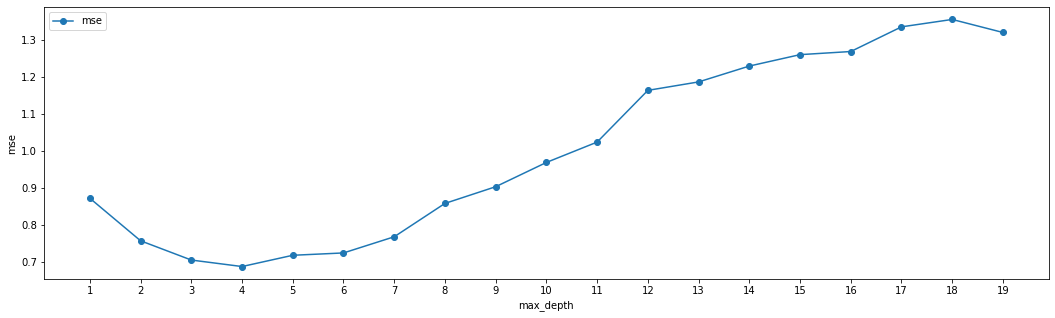

In [44]:
# visualizing changes in parameters
plt.figure(figsize=(18,5))
plt.plot('max_depth','acc_depth', data=d1, label='mse', marker="o")
plt.xticks(np.arange(1,20))

plt.xlabel('max_depth')
plt.ylabel('mse')
plt.legend()

The following code retrieves the optimal parameter and prunes the tree. Here, instead of choosing the parameter that minimizes the mean-squared-error, we're following another common heuristic: we will choose the most regularized model whose error is within one standard error of the minimum error.

In [120]:
# We get the best parameters
best_max_depth = d1[d1["acc_depth"] == np.min(d1["acc_depth"])].iloc[0,1]
best_ccp = d2[d2["acc_gini"] == np.min(d2["acc_gini"])].iloc[0,1]

# Prune the tree
dt = DecisionTreeRegressor(max_depth=best_max_depth , ccp_alpha= best_ccp , random_state=0)
tree1 = dt.fit(x_train,y_train)

Plotting the pruned tree. See also the package [rpart.plot](http://www.milbo.org/rpart-plot/prp.pdf) for more advanced plotting capabilities.
```{r}

In [ ]:
from sklearn import tree
plt.figure(figsize=(25,16))
tree.plot_tree(dt, filled=True, rounded=True, feature_names = XX.columns);

Finally, here’s how to extract predictions and mse estimates from the pruned tree.

In [122]:
y_pred = dt.predict(x_test)
mse = mean_squared_error(y_test, y_pred)

print("Tree MSE estimate:", mse)

Tree MSE estimate: 0.5442705453177679



It’s often said that trees are "interpretable." To some extent, that’s true – we can look at the tree and clearly visualize the mapping from inputs to prediction. This can be important in settings in which conveying how one got to a prediction is important. For example, if a decision tree were to be used for credit scoring, it would be easy to explain to a client how their credit was scored.

Beyond that, however, there are several reasons for not interpreting the obtained decision tree further. First, even though a tree may have used a particular variable for a split, that does not mean that it’s indeed an important variable: if two covariates are highly correlated, the tree may split on one variable but not the other, and there’s no guarantee which variables are relevant in the underlying data-generating process.

Similar to what we did for Lasso above, we can estimate the average value of each covariate per leaf. Although results are noisier here because there are many leaves, we see somewhat similar trends in that houses with higher predictions are also correlated with more bedrooms, bathrooms and room sizes.

In [40]:
from pandas import Series
from simple_colors import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm

In [41]:
y_pred
num_leaves = len(pd.Series(y_pred).unique())

categ = pd.Categorical(y_pred, categories= np.sort(pd.unique(y_pred)))
leaf = categ.rename_categories(np.arange(1,len(categ.categories)+1))

data1 = pd.DataFrame(data=x_test, columns= covariates)
data1["leaf"] = leaf

for var_name in covariates:
    form2 = var_name + " ~ " + "0" + "+" + "leaf"
    ols = smf.ols(formula=form2, data=data1).fit(cov_type = 'HC2').summary2().tables[1].iloc[:, 0:2].T
    print(red(var_name, 'bold'),ols, "\n")

LOT                leaf[1]        leaf[2]       leaf[3]       leaf[4]  \
Coef.     76491.899559  129102.123280  35058.201371  59815.230609   
Std.Err.  12405.242699   17921.335635   2134.642203  11159.843199   

               leaf[5]       leaf[6]       leaf[7]       leaf[8]       leaf[9]  
Coef.     37474.451548  44275.523233  54379.653727  49666.380327  77444.878973  
Std.Err.   2632.981719   2282.706417   3883.339922   4296.772925   7871.645357   

UNITSF               leaf[1]      leaf[2]      leaf[3]      leaf[4]      leaf[5]  \
Coef.     1253.436921  1919.370259  1564.492235  5085.737805  1368.844174   
Std.Err.    43.006720   151.630637    12.265223   375.593742     5.763695   

              leaf[6]      leaf[7]      leaf[8]      leaf[9]  
Coef.     2087.609012  3608.566364  3138.982620  8380.256000  
Std.Err.     5.101007    69.986674    14.813386   228.071867   

BUILT               leaf[1]      leaf[2]      leaf[3]      leaf[4]      leaf[5]  \
Coef.     1982.409326  1986.65


Finally, as we did in the linear model case, we can use the same code for an annotated version of the same information. Again, we ordered the rows in decreasing order based on an estimate of the relative variance "explained" by leaf membership: $Var(E[X_i|L_i]) / Var(X_i)$, where $L_i$ represents the leaf.


Text(0.5, 1.0, 'Average covariate values within leaf')

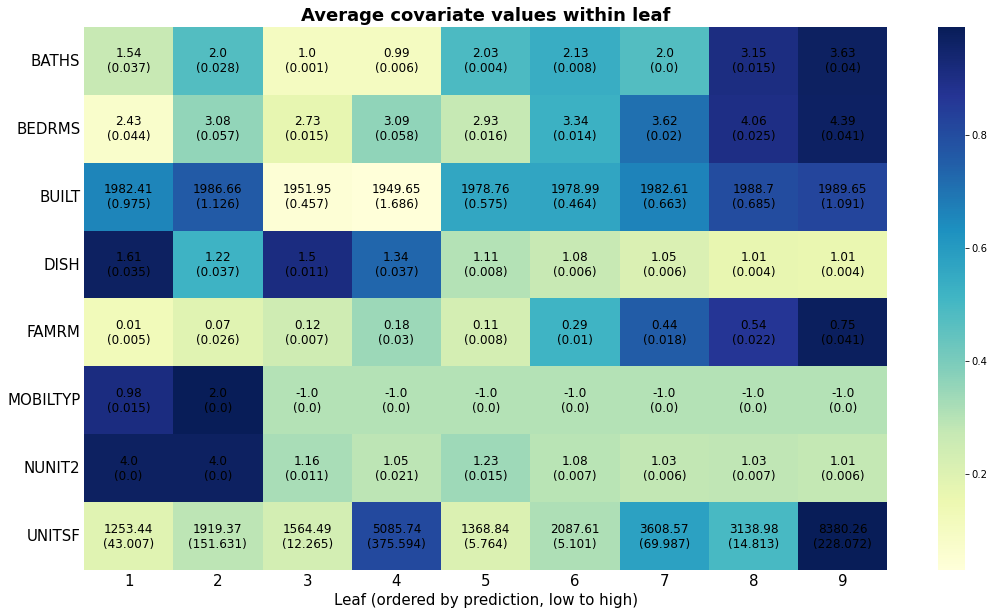

In [227]:
df = pd.DataFrame()
for var_name in covariates:
    form2 = var_name + " ~ " + "0" + "+" + "leaf"
    ols = smf.ols(formula=form2, data=data1).fit(cov_type = 'HC2').summary2().tables[1].iloc[:, 0:2]
    
    # Retrieve results
    toget_index = ols["Coef."]
    index = toget_index.index
    cova1 = pd.Series(np.repeat(var_name,num_leaves), index = index, name = "covariate")
    avg = pd.Series(ols["Coef."], name="avg")
    stderr = pd.Series(ols["Std.Err."], name = "stderr")
    ranking = pd.Series(np.arange(1,num_leaves+1), index = index, name = "ranking")
    scaling = pd.Series(norm.cdf((avg - np.mean(avg))/np.std(avg)), index = index, name = "scaling")
    data2 = pd.DataFrame(data=x_test, columns= covariates)
    variation1= np.std(avg) / np.std(data2[var_name])
    variation = pd.Series(np.repeat(variation1, num_leaves), index = index, name = "variation")
    labels = pd.Series(round(avg,2).astype('str') + "\n" + "(" + round(stderr, 3).astype('str') + ")", index = index, name = "labels")
    
    # Tally up results
    df1 = pd.DataFrame(data = [cova1, avg, stderr, ranking, scaling, variation, labels]).T
    df = df.append(df1)

# a small optional trick to ensure heatmap will be in decreasing order of 'variation'
df = df.sort_values(by = ["variation", "covariate"], ascending = False)

df = df.iloc[0:(8*num_leaves), :]
df1 = df.pivot(index = "covariate", columns = "ranking", values = ["scaling"]).astype(float)
labels =  df.pivot(index = "covariate", columns = "ranking", values = ["labels"]).to_numpy()

# plot heatmap
ax = plt.subplots(figsize=(18, 10))
ax = sns.heatmap(df1, 
                 annot=labels,
                 annot_kws={"size": 12, 'color':"k"},
                 fmt = '',
                 cmap = "YlGnBu",
                 linewidths=0,
                 xticklabels = ranking)
plt.tick_params( axis='y', labelsize=15, length=0, labelrotation=0)
plt.tick_params( axis='x', labelsize=15, length=0, labelrotation=0)
plt.xlabel("Leaf (ordered by prediction, low to high)", fontsize= 15)
plt.ylabel("")
ax.set_title("Average covariate values within leaf", fontsize=18, fontweight = "bold")

### Forest


Forests are a type of **ensemble** estimators: they aggregate information about many decision trees to compute a new estimate that typically has much smaller variance.

At a high level, the process of fitting a (regression) forest consists of fitting many decision trees, each on a different subsample of the data. The forest prediction for a particular point $x$ is the average of all tree predictions for that point.

One interesting aspect of forests and many other ensemble methods is that cross-validation can be built into the algorithm itself. Since each tree only uses a subset of the data, the remaining subset is effectively a test set for that tree. We call these observations **out-of-bag** (there were not in the “bag” of training observations). They can be used to evaluate the performance of that tree, and the average of out-of-bag evaluations is evidence of the performance of the forest itself.

For the example below, we’ll use the regression_forest function of the `R` package `grf`. The particular forest implementation in `grf` has interesting properties that are absent from most other packages. For example, trees are build using a certain sample-splitting scheme that ensures that predictions are approximately unbiased and normally distributed for large samples, which in turn allows us to compute valid confidence intervals around those predictions. We’ll have more to say about the importance of these features when we talk about causal estimates in future chapters. See also the grf website for more information.

In [7]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor

In [8]:
forest = RandomForestRegressor(n_estimators=200, oob_score=True)
#x_train, x_test, y_train, y_test = train_test_split(XX.to_numpy() , Y, test_size=.3)
forest.fit(x_train, y_train)
# Retrieving forest predictions
rf_pred = forest.predict(x_test)

# Evaluation
mse = mean_squared_error(y_test, rf_pred)

print("Forest MSE:", mse)

Forest MSE: 0.5873930432041589



The fitted attribute `feature_importances_` computes the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature.


In [11]:
feature_importance = pd.DataFrame(forest.feature_importances_, index=covariates, columns= ["importance"])
importance = feature_importance.sort_values(by=["importance"], ascending=False)
importance[:10].T

,UNITSF,NUNIT2,BATHS,MOBILTYP,LOT,noise2,noise10,noise18,noise14,noise17
importance,0.147069,0.112232,0.06445,0.051078,0.033354,0.029163,0.027714,0.026012,0.025877,0.024181


Text(0.5, 1.0, 'Variable Importance')

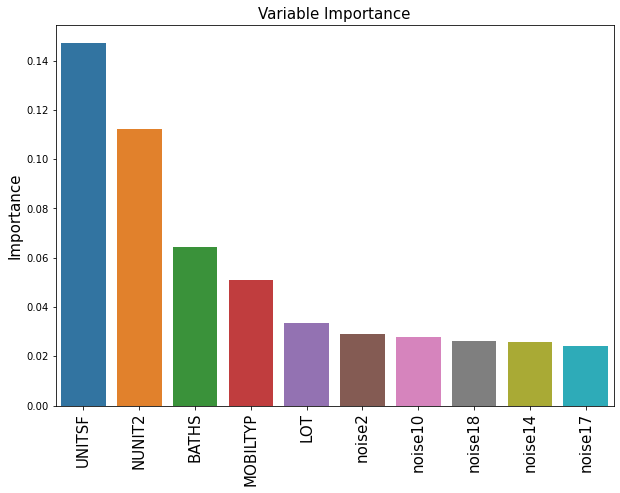

In [12]:
plt.figure(figsize=(10,7))
sns.barplot(importance.index[:10],importance.importance[:10])
plt. xticks(rotation= 90, fontsize=15)
plt.yticks(fontsize=10)
plt.ylabel("Importance",fontsize=15)
plt.title("Variable Importance", fontsize=15)


All the caveats about interpretation that we mentioned above apply in a similar to forest output.


## Further reading


In this tutorial we briefly reviewed some key concepts that we recur later in this tutorial. For readers who are entirely new to this field or interested in learning about it more depth, the first few chapters of the following textbook are an acccessible introduction:

James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning (Vol. 112, p. 18). New York: springer. Available for free at [the authors’ website](https://www.statlearning.com/).

Some of the discussion in the Lasso section in particular was drawn from [Mullainathan and Spiess (JEP, 2017)](https://www.aeaweb.org/articles?id=10.1257/jep.31.2.87), which contains a good discussion of the interpretability issues discussed here.

There has been a good deal of research on inference in high-dimensional models, Although we won’t be covering in depth it in this tutorial, we refer readers to [Belloni, Chernozhukov and Hansen (JEP, 2014)](http://www.mit.edu/~vchern/papers/JEP.pdf). Also check out the related `R` package [`hdm`](https://cran.r-project.org/web/packages/hdm/hdm.pdf), developed by the same authors, along with Philipp Bach and Martin Spindler.